In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from sklearn.utils import shuffle
# from tensorflow.metrics import F1Score
import numpy as np
import os
import cv2
import tensorflow.keras.backend as K


import wandb
from wandb.keras import WandbCallback

In [2]:
DATADIR = "data/Training/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 64
training_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,class_num])



In [3]:
DATADIR = "data/Testing/"
CATEGORIES = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
IMG_SIZE = 64
testing_data = []

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        testing_data.append([new_array,class_num])


In [4]:
wandb.login()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nsfitt-pa (use `wandb login --relogin` to force relogin)


True

In [5]:
test_X = []
test_y = []

for image, label in testing_data:
    test_X.append(image)
    test_y.append(label)

test_X = np.array(test_X).reshape(-1,IMG_SIZE,IMG_SIZE)
test_X = test_X/127.0 - 1
test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = np.array(test_y)

test_X, test_y = shuffle(test_X, test_y)

In [6]:
train_X = []
train_y = []

for image, label in training_data:
    train_X.append(image)
    train_y.append(label)

train_X = np.array(train_X).reshape(-1,IMG_SIZE,IMG_SIZE)
train_X = train_X/127.0 - 1
train_X = train_X.reshape(-1,IMG_SIZE,IMG_SIZE,1)
train_y = np.array(train_y)

train_X, train_y = shuffle(train_X, train_y)

In [7]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:

config = {
    "epochs": 20,
    "batch_size": 256,
    "dropout": 0,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "Adam",
    "dataset": "wine quality"
}

run = wandb.init(project='nsfitt-pa', entity='nsfitt-pa')
wandb.config.update(config)

wandb: wandb version 0.10.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [9]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation = "softmax"))

model.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=[get_f1, 'accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [10]:
my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True),
    WandbCallback(monitor='val_loss', mode='min', save_model=True)
]

history = model.fit(train_X, train_y, batch_size=config['batch_size'], epochs=config['epochs'], validation_split=0.2, callbacks=my_callbacks)

Epoch 1/20
18/18 [==============================] - 11s 624ms/step - loss: 1.2182 - get_f1: 2.0228 - accuracy: 0.4817 - val_loss: 1.1396 - val_get_f1: 1.3114 - val_accuracy: 0.5013
Epoch 2/20
18/18 [==============================] - 11s 636ms/step - loss: 1.1230 - get_f1: 1.4874 - accuracy: 0.4985 - val_loss: 1.0789 - val_get_f1: 1.3530 - val_accuracy: 0.4881
Epoch 3/20
18/18 [==============================] - 11s 604ms/step - loss: 1.0278 - get_f1: 1.5423 - accuracy: 0.5209 - val_loss: 0.9256 - val_get_f1: 1.6210 - val_accuracy: 0.6000
Epoch 4/20
18/18 [==============================] - 11s 605ms/step - loss: 0.9078 - get_f1: 1.3627 - accuracy: 0.5968 - val_loss: 0.8268 - val_get_f1: 1.2153 - val_accuracy: 0.6150
Epoch 5/20
18/18 [==============================] - 11s 616ms/step - loss: 0.7837 - get_f1: 1.1519 - accuracy: 0.6230 - val_loss: 0.7619 - val_get_f1: 1.1829 - val_accuracy: 0.6370
Epoch 6/20
18/18 [==============================] - 11s 608ms/step - loss: 0.6770 - get_f1: 1.0

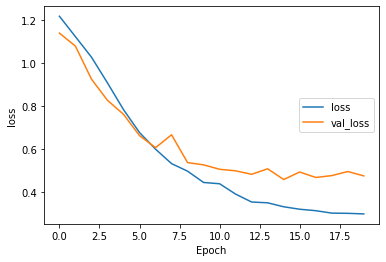

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='right')

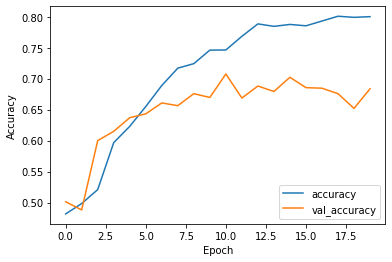

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [16]:
dependencies = {
    'get_f1': get_f1
}
 
# load model
model = tf.keras.models.load_model('model.h5', custom_objects=dependencies)

y_pred = model.predict(test_X)
y_pred = np.argmax(y_pred,axis=1)

In [17]:
from sklearn.metrics import classification_report,confusion_matrix

clf_report = classification_report(test_y,y_pred, target_names=CATEGORIES, output_dict=True)
clf_report_str = classification_report(test_y,y_pred, target_names=CATEGORIES)
print(clf_report)
print(clf_report_str)

{'glioma_tumor': {'precision': 0.6363636363636364, 'recall': 0.35, 'f1-score': 0.45161290322580644, 'support': 100}, 'meningioma_tumor': {'precision': 0.7086092715231788, 'recall': 0.9304347826086956, 'f1-score': 0.8045112781954887, 'support': 115}, 'no_tumor': {'precision': 0.6524822695035462, 'recall': 0.8761904761904762, 'f1-score': 0.7479674796747967, 'support': 105}, 'pituitary_tumor': {'precision': 0.9787234042553191, 'recall': 0.6216216216216216, 'f1-score': 0.7603305785123967, 'support': 74}, 'accuracy': 0.7106598984771574, 'macro avg': {'precision': 0.7440446454114201, 'recall': 0.6945617201051983, 'f1-score': 0.6911055599021222, 'support': 394}, 'weighted avg': {'precision': 0.7260472083103938, 'recall': 0.7106598984771574, 'f1-score': 0.6915764860173422, 'support': 394}}
                  precision    recall  f1-score   support

    glioma_tumor       0.64      0.35      0.45       100
meningioma_tumor       0.71      0.93      0.80       115
        no_tumor       0.65     

In [15]:

wandb.log({'Accuracy_test': clf_report['accuracy']})
wandb.log({'glioma_tumor_f1': clf_report['glioma_tumor']['f1-score']})
wandb.log({'meningioma_tumor_f1': clf_report['meningioma_tumor']['f1-score']})
wandb.log({'no_tumor_f1': clf_report['no_tumor']['f1-score']})
wandb.log({'pituitary_tumor_f1': clf_report['pituitary_tumor']['f1-score']})
run.finish()


Run pip install nbformat to save notebook history


epoch,19
loss,0.29828
get_f1,0.94621
accuracy,0.80004
val_loss,0.47524
val_get_f1,0.94861
val_accuracy,0.6837
_runtime,236
_timestamp,1618088020
_step,24
best_val_loss,0.45831


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▇▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
get_f1,█▅▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▂▄▄▅▆▆▆▇▇▇████████
val_loss,█▇▆▅▄▃▃▃▂▂▁▁▁▂▁▁▁▁▁▁
val_get_f1,▅▅█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▅▆▆▇▆▇▇█▇▇▇█▇▇▇▆▇
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███████
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Accuracy_test,▁
